In [152]:
import sqlite3
import re
import os
import shutil
import sys
import datetime
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [228]:
def get_data(local_authority):

    db_connect = sqlite3.connect("C:\\Users\\darry\\Documents\\Y2Q3_Data-Challenge-2\\dc2-policeuk.db")
    cursor = db_connect.cursor()

    query = "SELECT * FROM Crime WHERE DATE(Month) BETWEEN '2015-01-01' AND '2020-01-01' AND LocalAuthority = \'" + local_authority + "\';"
    
    global df_crime

    df_crime = pd.read_sql_query(query, db_connect)

    cursor.close()
    db_connect.close()
    
    return df_crime

def get_timeseries(df):
    
    years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
    months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    
    df['Month'] = pd.to_datetime(df['Month'])
    
    monthly_crime = pd.DataFrame()
    
    for year in years:
        for month in months:
            df_temp = df[df['Month'] == datetime.datetime(year, month, 1)]
            if len(df_temp) == 0:
                continue
            else:
                month_total = pd.DataFrame({'Month': [datetime.datetime(year, month, 1)], 'Total': [len(df_temp)]})
                crimetypes = df_temp['CrimeType'].value_counts().to_frame().transpose().reset_index(drop=True)
                df_temp = pd.concat([month_total, crimetypes], axis=1)
                monthly_crime = monthly_crime.append(df_temp, ignore_index=True)
                
    monthly_crime.set_index('Month', inplace=True)
    
    return monthly_crime

def get_HWESforecast(df):
    crimes = list(df)
    train_test_split = round(0.80 * len(df))
    df_train = df.iloc[:train_test_split]
    df_test = df.iloc[train_test_split + 1:]
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(30)
    x=1
    for crime in crimes:
        model = ExponentialSmoothing(df_train[crime], seasonal='add', trend ='add',seasonal_periods=12).fit()
        predictions = model.forecast(steps=11)
        mse = ((np.array(df_test[crime].tolist()) - np.array(predictions.tolist()))**2).mean()
        ax = fig.add_subplot(4,4,x)
        ax.set_title('MSE: ' + str(mse))
        df_train[crime].plot(legend=True, label='Previous (train) ' + crime, ax=ax)
        df_test[crime].plot(legend=True, label='True (test) ' + crime, ax=ax)
        predictions.plot(legend=True, label='Forecasted (predicted) ' + crime, ax=ax)
        x += 1
    return fig

def hwes_forecast(local_authority):
    df_crime = get_data(local_authority)
    monthly_crime = get_timeseries(df_crime)
    return get_HWESforecast(monthly_crime)

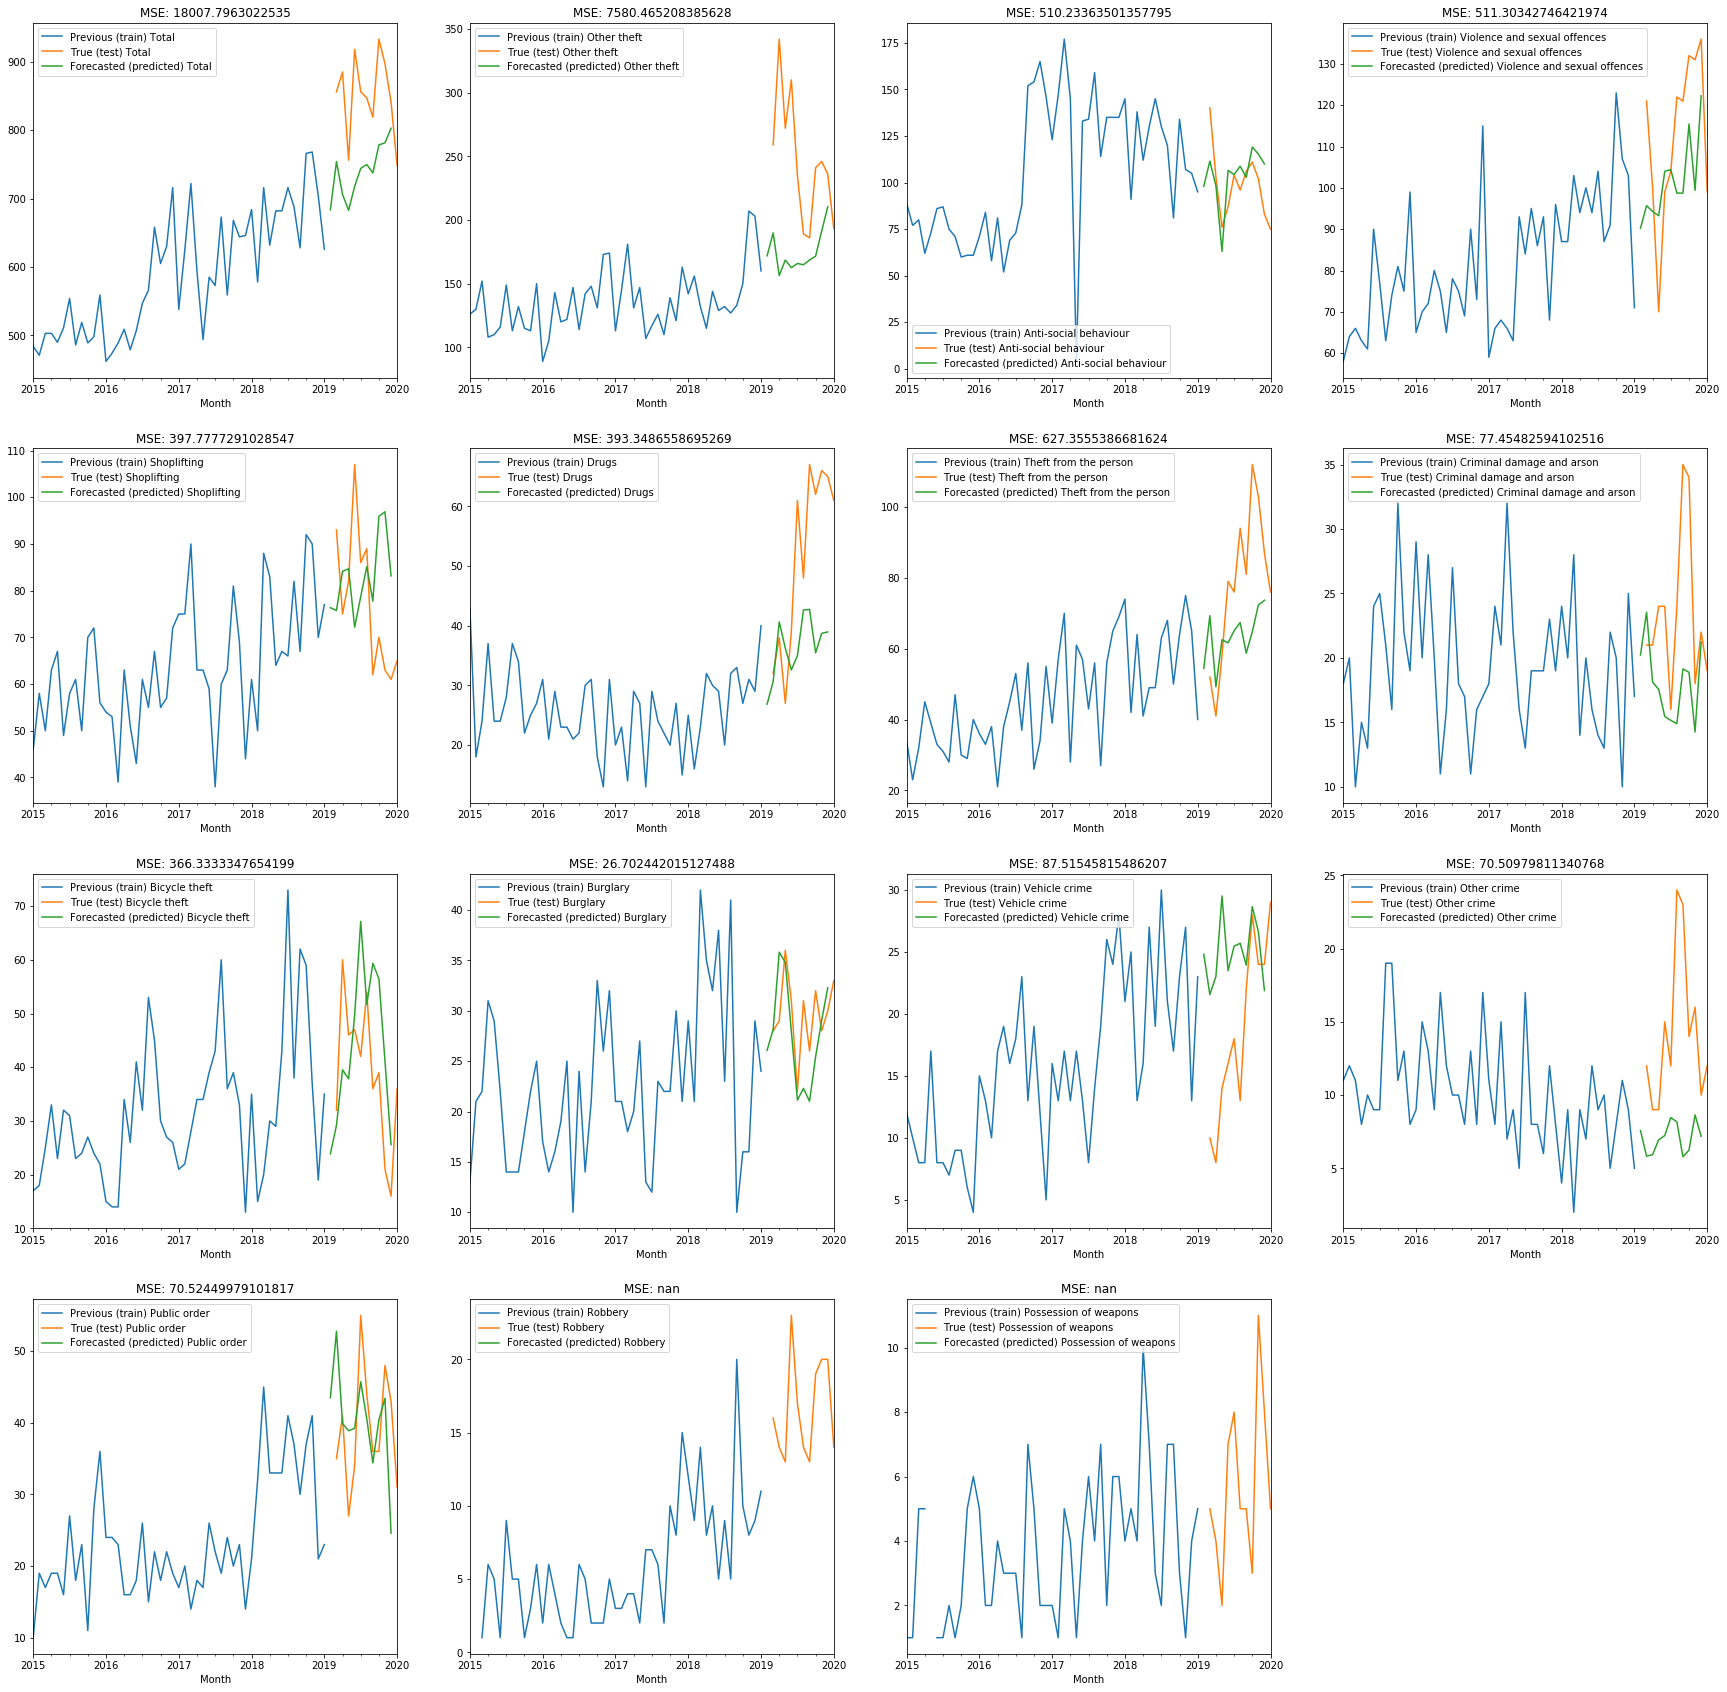

In [229]:
data = hwes_forecast('City of London')

In [230]:
data.savefig('Holt-Winters-London')